# Load and plot the pre-prepared seabed currents

In [1]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask import delayed
from dask_jobqueue import SLURMCluster

In [2]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(24)
client

<Client: scheduler='tcp://146.118.38.76:37913' processes=0 cores=0>

In [3]:
# Open necessary python packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt



In [4]:
%matplotlib inline

In [5]:
plt.rcParams["font.size"] = "14"
plt.rcParams['axes.labelsize']='large'

In [24]:
# Command to load a netcdf file (or group of files here) as an xarray.Dataset object
basedir = '/scratch/pawsey0106/mrayson/SUNTANS/NWS/SCENARIOS/OUTPUT_NWS_2km_hex_2013_2014/compressed'
ncfile = '{}/NWS_2km_hex_*_seabed_interp_c.nc'.format(basedir)
dsall = xr.open_mfdataset(ncfile,
            chunks={}, parallel=True)
dsall

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


<xarray.Dataset>
Dimensions:    (latitude: 750, longitude: 1250, time: 8543)
Coordinates:
  * latitude   (latitude) float64 -23.0 -22.98 -22.96 ... -8.06 -8.04 -8.02
  * longitude  (longitude) float64 110.0 110.0 110.0 110.1 ... 134.9 135.0 135.0
  * time       (time) datetime64[ns] 2013-07-01T00:00:30 ... 2014-06-21T10:15:00
Data variables:
    temp       (time, latitude, longitude) float64 dask.array<shape=(8543, 750, 1250), chunksize=(745, 750, 1250)>
    uc         (time, latitude, longitude) float64 dask.array<shape=(8543, 750, 1250), chunksize=(745, 750, 1250)>
    vc         (time, latitude, longitude) float64 dask.array<shape=(8543, 750, 1250), chunksize=(745, 750, 1250)>
    z          (time, latitude, longitude) float64 dask.array<shape=(8543, 750, 1250), chunksize=(745, 750, 1250)>
Attributes:
    Name:          North West Shelf SUNTANS seabed data
    Date created:  2019:08:28 16:37:36
    Author:        Matt Rayson
    Institution:   University of Western Australia
    Inp

In [25]:
# Subset
ds = dsall.sel(latitude=slice(-22,-10,None), longitude=slice(110,130))\
    .chunk({'longitude':10,'latitude':10, 'time':-1})
ds

<xarray.Dataset>
Dimensions:    (latitude: 600, longitude: 1001, time: 8543)
Coordinates:
  * latitude   (latitude) float64 -21.98 -21.96 -21.94 ... -10.04 -10.02 -10.0
  * longitude  (longitude) float64 110.0 110.0 110.0 110.1 ... 130.0 130.0 130.0
  * time       (time) datetime64[ns] 2013-07-01T00:00:30 ... 2014-06-21T10:15:00
Data variables:
    temp       (time, latitude, longitude) float64 dask.array<shape=(8543, 600, 1001), chunksize=(8543, 10, 10)>
    uc         (time, latitude, longitude) float64 dask.array<shape=(8543, 600, 1001), chunksize=(8543, 10, 10)>
    vc         (time, latitude, longitude) float64 dask.array<shape=(8543, 600, 1001), chunksize=(8543, 10, 10)>
    z          (time, latitude, longitude) float64 dask.array<shape=(8543, 600, 1001), chunksize=(8543, 10, 10)>
Attributes:
    Name:          North West Shelf SUNTANS seabed data
    Date created:  2019:08:28 16:37:36
    Author:        Matt Rayson
    Institution:   University of Western Australia
    Input Fi

In [33]:
# Calculate the speed
#spd = np.abs(ds.uc + 1j*ds.vc)
spd = np.sqrt(ds.uc*ds.uc + ds.vc*ds.vc)
spd = spd.persist()

In [27]:
# Persist speed in memory for quicker calculations later
#spd.persist()

In [28]:
# Calculate the maximum speed
maxspd = spd.max(axis=0).compute()


In [44]:
def percentile(obj, dim, p):
    # note: apply always moves core dimensions to the end
    return xr.apply_ufunc(np.percentile, obj, p,
                           kwargs={'axis': -1})


In [45]:
spd95 = percentile(spd, 'time', 95)
#spd95.compute()

ValueError: apply_ufunc encountered a dask array on an argument, but handling for dask arrays has not been enabled. Either set the ``dask`` argument or load your data into memory first with ``.load()`` or ``.compute()``

In [10]:
# Get the depth
dv = ds.z[0,...].compute()
dv.shape

(600, 1001)

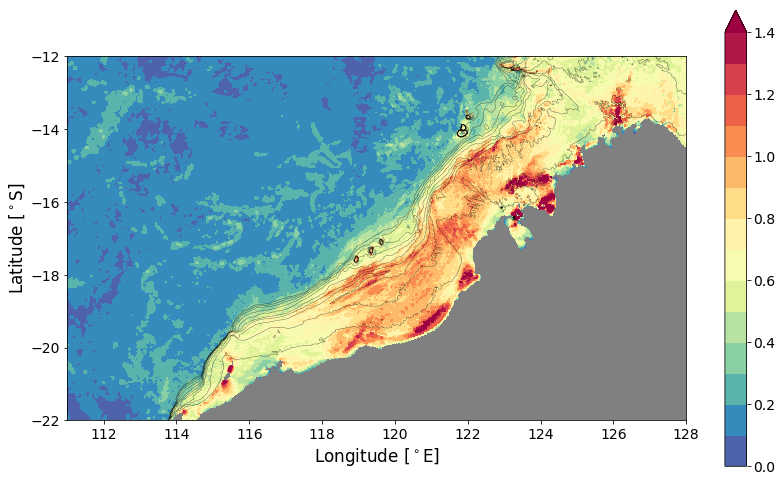

In [14]:
# plot the max speed
plt.figure(figsize=(12,7))
ax=plt.subplot(111, facecolor='0.5')
#spd.max(axis=0).plot(vmax=1.5, cmap='Reds')
plt.contourf(ds.longitude, ds.latitude, maxspd,\
    np.arange(0,1.5,0.1), cmap='Spectral_r',extend='max')
plt.colorbar()

plt.contour(ds.longitude, ds.latitude, dv, 
            [10,50,100,150,200,250,300, 350,400,450,500],
           colors='k',linewidths=0.25)
plt.xlim(111,128)
plt.ylim(-22,-12)
plt.gca().set_aspect('equal')
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')

plt.tight_layout()
plt.savefig('../FIGURES/SUNTANS_max_seabed_uv_Shelf.png',dpi=150)

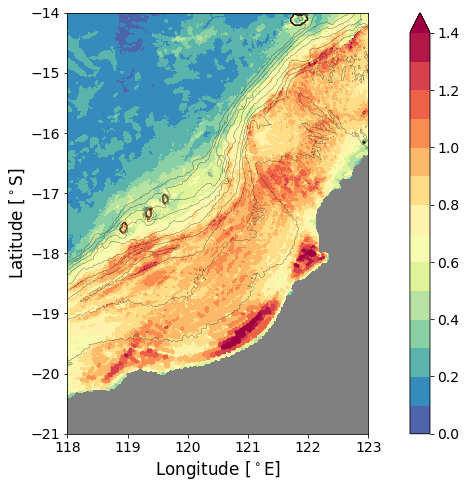

In [15]:
plt.figure(figsize=(12,7))
ax=plt.subplot(111, facecolor='0.5')
#spd.max(axis=0).plot(vmax=1.5, cmap='Reds')
plt.contourf(ds.longitude, ds.latitude, maxspd,\
    np.arange(0,1.5,0.1), cmap='Spectral_r',extend='max')
plt.colorbar()

plt.contour(ds.longitude, ds.latitude, dv, 
            [10,50,100,150,200,250,300, 350,400,450,500],
           colors='k',linewidths=0.25)
plt.xlim(118,123)
plt.ylim(-21,-14)
plt.gca().set_aspect('equal')
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')

plt.tight_layout()
plt.savefig('../FIGURES/SUNTANS_max_seabed_uv_Roebuck.png',dpi=150)

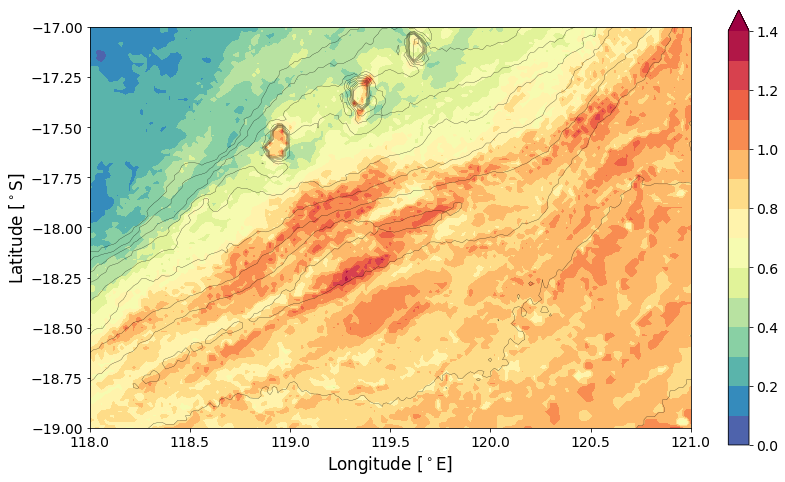

In [16]:
plt.figure(figsize=(12,7))
ax=plt.subplot(111, facecolor='0.5')
#spd.max(axis=0).plot(vmax=1.5, cmap='Reds')
plt.contourf(ds.longitude, ds.latitude, maxspd,\
    np.arange(0,1.5,0.1), cmap='Spectral_r',extend='max')
plt.colorbar()

plt.contour(ds.longitude, ds.latitude, dv, 
            [10,50,100,150,200,250,300, 350,400,450,500],
           colors='k',linewidths=0.25)
plt.xlim(118,121)
plt.ylim(-19,-17)
plt.gca().set_aspect('equal')
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')

plt.tight_layout()
plt.savefig('../FIGURES/SUNTANS_max_seabed_uv_Rowleys.png',dpi=150)

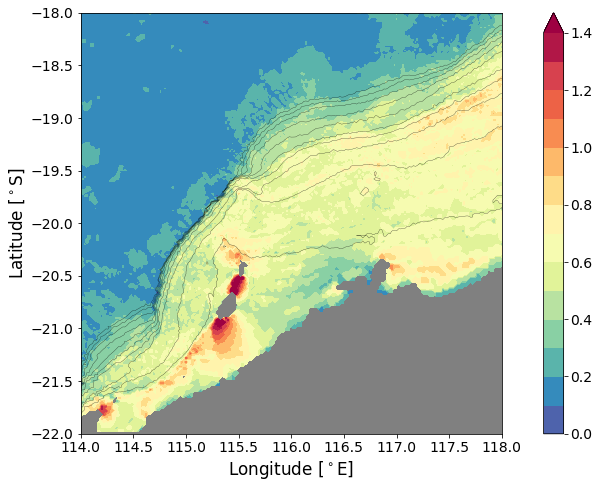

In [17]:
plt.figure(figsize=(12,7))
ax=plt.subplot(111, facecolor='0.5')
#spd.max(axis=0).plot(vmax=1.5, cmap='Reds')
plt.contourf(ds.longitude, ds.latitude, maxspd,\
    np.arange(0,1.5,0.1), cmap='Spectral_r',extend='max')
plt.colorbar()

plt.contour(ds.longitude, ds.latitude, dv, 
            [10,50,100,150,200,250,300, 350,400,450,500],
           colors='k',linewidths=0.25)
plt.xlim(114,118)
plt.ylim(-22,-18)
plt.gca().set_aspect('equal')
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')

plt.tight_layout()
plt.savefig('../FIGURES/SUNTANS_max_seabed_uv_Pilbara.png',dpi=150)

In [20]:
# Save the data to a geotiff
from soda.utils.maptools import save_raster
save_raster('../FIGURES/SUNTANS_max_seabed_uv.tif', maxspd.values, ds.longitude.values,\
            ds.latitude.values)


In [6]:
# Grab a time-series and plot
ds_station = ds.sel(longitude=120, latitude=-19,method='nearest')
ds_station

<xarray.Dataset>
Dimensions:    (time: 1490)
Coordinates:
    latitude   float64 -19.0
    longitude  float64 120.0
  * time       (time) datetime64[ns] 2013-07-01T00:00:30 2013-07-01T01:00:00 ...
Data variables:
    temp       (time) float64 dask.array<shape=(1490,), chunksize=(745,)>
    uc         (time) float64 dask.array<shape=(1490,), chunksize=(745,)>
    vc         (time) float64 dask.array<shape=(1490,), chunksize=(745,)>
    z          (time) float64 dask.array<shape=(1490,), chunksize=(745,)>
Attributes:
    Name:          North West Shelf SUNTANS seabed data
    Date created:  2019:08:28 16:37:36
    Author:        Matt Rayson
    Institution:   University of Western Australia
    Input Files:   ../SCENARIOS/NWS_2km_hex_2013_2014_data1/NWS_2km_hex_20130...
    history:       Wed Aug 28 17:26:22 2019: ncks -7 --cnk_dmn time,100 --ppc...
    NCO:           netCDF Operators version 4.7.6 (Homepage = http://nco.sf.n...

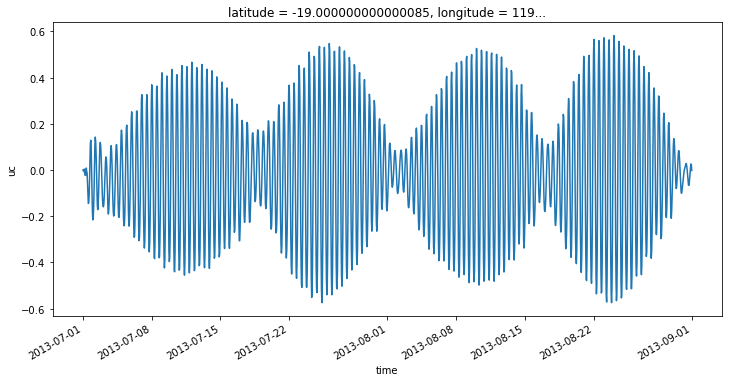

In [11]:
plt.figure(figsize=(12,6))
ds_station.uc.plot()

<xarray.DataArray 'z' ()>
array(10.)
Coordinates:
    time     datetime64[ns] 2013-07-01T00:00:30